# Austin Bikeshare
Data comes from bigquery public datasets.

My aim is finding patterns among people with a specific type of subscription.
My first try of using maps with python. 

python = 3.9 for merging dict by | operator


In [151]:
#own settings of jupyer
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

importing libraries

In [152]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline
from matplotlib.ticker import MaxNLocator
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
from sklearn import preprocessing
import datetime

from pandas.api.types import CategoricalDtype

import ipywidgets
from ipyleaflet import Map, Marker, CircleMarker

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent = 'bike_share_austin')

In [153]:
#cell for function used here
def make_coordinates(address):
    location = geolocator.geocode(str(address) + ' Austin')
    if location is None:
        return 0,0
    return location.latitude, location.longitude
def rgb_to_hex(red, green, blue):
    """Return color as #rrggbb for the given color values."""
    return '#%02x%02x%02x' % (red, green, blue)

def draw_map(stations):
    #preparing map visualisation
    center = (30.2672, -97.7431)#austion coordinates from google
    m = Map(center=center, zoom = 11)
    for i in range(len(stations)):
        address = stations.latitude.iloc[i], stations.longitude.iloc[i]
        if stations.frequency.iloc[i] == 0:
            rgb_color = (215,215,215)

        else:
            rgb_color = (0,255-int(255*stations.normalized_freq.iloc[i]),255)
        hex_color = rgb_to_hex(*rgb_color)
        circle_marker = CircleMarker(location = address, radius = 2, color = hex_color)
        m.add_layer(circle_marker)
    return m
    

# Data
I have decided to create my own ids for stations (smaller numbers) as I don't know if there is any pattern in naming. I hope it will help in visualizing data

In [154]:
"""stations = pd.read_csv('austin_bikeshare_stations.csv')
stations['adress'] = stations.address.astype('str')
stations[['latitude','longitude']] = stations.address.apply(make_coordinates).apply(pd.Series)
stations.to_csv('austin bikeshare_stations_coordinates.csv')
"""
stations = pd.read_csv('austin bikeshare_stations_coordinates.csv')
stations_colnames = list(stations.columns)
#unused_stations = stations.sort_values(by = 'station_id', ascending = False).head(len(all_ids) - len(ids)).reset_index(drop = True)
#used_stations = pd.concat([stations, unused_stations]).drop_duplicates(keep = False)


In [155]:
trips = pd.read_csv('austin_bikeshare_trips.csv')
#Finding unconsistent data in end_station_id column  and cleaning end_station_id
trips_end_nan = trips[trips.end_station_id.isnull()]
trips_end_str = trips[trips['end_station_id'].str.contains('^[a-zA-Z]+$')==True]
trips_wo_end = pd.concat([trips_end_nan,trips_end_str])
trips = pd.concat([trips, trips_wo_end]).drop_duplicates(keep = False)
trips = trips.astype({'end_station_id' : int})
trips = trips.reset_index(drop = True)
trips['day_of_week'] = pd.to_datetime(trips.start_time).dt.day_name()
cats = ['Monday', 'Tuesday','Wednesday','Thursday', 'Friday', 'Saturday','Sunday']
trips['hour'] = pd.to_datetime(trips.start_time).dt.hour
time_outliers_limit = trips['duration_minutes'].quantile(0.95)#.duration_minutes.mean()
new_time_mean = trips[trips['duration_minutes']<=time_outliers_limit].duration_minutes.mean()
trips.loc[trips['duration_minutes'] > time_outliers_limit, 'duration_minutes'] = new_time_mean

In [156]:
old_ids = pd.concat([trips.start_station_id, trips.end_station_id, stations.station_id])
old_ids = old_ids.drop_duplicates().sort_values().reset_index(drop=True)
new_ids = [i+1 for i in range(len(old_ids))]
dict_ids = dict(zip(old_ids, new_ids))


trips = trips.replace({'start_station_id':dict_ids,'end_station_id':dict_ids})
stations = stations.replace({'station_id':dict_ids})

coordinates = stations[['station_id','latitude','longitude']]
coordinates = coordinates[coordinates.latitude != 0 ]
coordinates = coordinates[coordinates.longitude != 0 ]

dict_freq = trips['end_station_id'].value_counts().to_dict()#station_id:frequency
df_freq = trips['end_station_id'].value_counts().to_frame()
df_freq = df_freq.reset_index().rename(columns = {'index':'station_id','end_station_id':'frequency'})
df_freq['frequency'] = df_freq['frequency'].fillna(0)
df_freq['normalized_freq'] = (df_freq['frequency']-df_freq['frequency'].min())/(df_freq['frequency'].max()-df_freq['frequency'].min())

coordinates = pd.merge(coordinates, df_freq, on = 'station_id', how = 'left').fillna(0)
#stations = pd.merge(stations, coordinates, how = 'left', on = 'station_id')

stations = pd.merge(stations, df_freq, how = 'left').fillna(0)

(array([ 772.,  146., 1906., 1516.,    0.,    0.,    0.,  272.,    0.,
        2278.,    0.,    0., 1991., 1490.,    0.,    0.,    0.,    0.,
           0.,    0., 2545.,    0.,    0., 1175., 1251., 1816., 2913.,
        3354.,  214.,    0.,  361.,    0.,  923.,    0., 1536., 1170.,
        1038.,    0.,    0.,    0.,  599., 1593.,  799., 1883., 1571.,
        4662., 3208.,  615.]),
 array([  3.        ,   5.08333333,   7.16666667,   9.25      ,
         11.33333333,  13.41666667,  15.5       ,  17.58333333,
         19.66666667,  21.75      ,  23.83333333,  25.91666667,
         28.        ,  30.08333333,  32.16666667,  34.25      ,
         36.33333333,  38.41666667,  40.5       ,  42.58333333,
         44.66666667,  46.75      ,  48.83333333,  50.91666667,
         53.        ,  55.08333333,  57.16666667,  59.25      ,
         61.33333333,  63.41666667,  65.5       ,  67.58333333,
         69.66666667,  71.75      ,  73.83333333,  75.91666667,
         78.        ,  80.08333333,  8

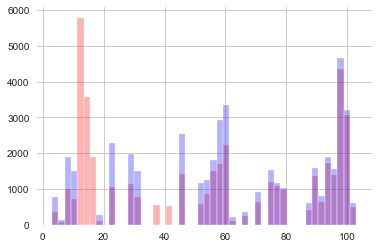

In [157]:
fig, ax = plt.subplots()
ax.hist(trips.end_station_id, bins = 48, fc = (1, 0, 0, 0.3))#czerwony
ax.hist(trips.start_station_id, bins = 48, fc = (0, 0, 1, 0.3))#niebieski

After seeing the above hist, I have decided to use 'end_station_id' for defining frequency of using stations

In [158]:
#finding patterns for type of member in using stations

In [159]:
subscriber_types = trips['subscriber_type'].value_counts().to_frame()
subscriber_types = subscriber_types.reset_index().rename(columns = {'index':'old_name', 'subscriber_type':'frequency'})

# Types of subscription
On the website https://austin.bcycle.com/ there are 7 types of using bike:
- Pay-as-you-ride 
$1 to unlock then just $.23 per minute after that
    
- Local31 $11.00
Monthly Membership includes unlimited 60-minute trips. $4 per each additional 30 minutes. Auto-Renew Enabled. ONE TIME $15 (+tax) ACTIVATION FEE.

- Explorer $12.99
Unlimited 60 minute trips during a 24 hour time period. Usage fees of $4 (+tax) begin after 60 minutes. Bike must be returned to station to restart trip time.

- 3-Day Weekender $19.49
$18 + tax. 72-Hr Access Pass includes unlimited 60-min trips.

- Local365 $86.60
Annual Membership includes unlimited 60-minute trips. $4 per each additional 30 minutes. B-connected access to other B-cycle cities included.

- Student Membership $86.60
Must apply for verification on the students page to receive discounted rate. Available for UT @ Austin and HTU student. Same rules as Local365 apply.

After reviewing data I have also decided to add my own category as I see it was really popular, although don't know specific rules for it
- Walk up

In [160]:
subscriber_types.value_counts()

old_name                                          frequency
$1 Pay by Trip Fall Special                       41           1
Founding Member (Austin B-cycle)                  54           1
Local30                                           1755         1
Local30 ($11 plus tax)                            22           1
Local31                                           2181         1
Local365                                          9817         1
Local365 ($80 plus tax)                           166          1
Local365 Youth (age 13-17 riders)                 9            1
Local365 Youth with helmet (age 13-17 riders)     1            1
Local365+Guest Pass                               261          1
Local365+Guest Pass- 1/2 off Anniversary Special  15           1
Local365- 1/2 off Anniversary Special             110          1
Madtown Monthly                                   2            1
Membership: pay once  one-year commitment         1            1
Pay-as-you-ride               

In [161]:
annuals = subscriber_types[subscriber_types['old_name'].str.contains('Annual')].old_name
annuals_dict = dict(zip(annuals.to_list(),['Annual']*len(annuals)))

local365 = subscriber_types[subscriber_types['old_name'].str.contains('Local365')].old_name
local365_dict = dict(zip(local365.to_list(),['Annual']*len(local365)))

local31 = subscriber_types[subscriber_types['old_name'].str.contains('Local3'+'[0-1]')].old_name
local31_dict = dict(zip(local31.to_list(),['Local30']*len(local31)))

explorer = subscriber_types[subscriber_types['old_name'].str.contains('Explorer')].old_name
explorer_dict = dict(zip(explorer.to_list(),['Explorer']*len(explorer)))

weekender = subscriber_types[subscriber_types['old_name'].str.contains('Weekender')].old_name
weekender_dict = dict(zip(weekender.to_list(),['Weekender']*len(weekender)))

pay = subscriber_types[subscriber_types['old_name'].str.contains('Pay-as')].old_name
pay_dict = dict(zip(pay.to_list(),['Pay']*len(pay)))

student = subscriber_types[subscriber_types['old_name'].str.contains('Student')].old_name
student_dict = dict(zip(student.to_list(),['Student']*len(student)))

walk_up = subscriber_types[subscriber_types['old_name'].str.contains('Walk')].old_name
walk_up_dict = dict(zip(walk_up.to_list(),['Student']*len(walk_up)))

new_values_dict = annuals_dict|local365_dict|explorer_dict|weekender_dict|pay_dict|student_dict|walk_up_dict

other = subscriber_types[~subscriber_types['old_name'].isin(list(new_values_dict.keys()))].old_name
other_dict = dict(zip(other.to_list(),['Other']*len(other)))

new_values_dict = new_values_dict|other_dict

In [162]:
trips = trips.replace({'subscriber_type':new_values_dict})

In [163]:
trips.subscriber_type.value_counts()

Student      13523
Annual       11265
Other        10055
Pay           4117
Explorer      2301
Weekender     2135
Name: subscriber_type, dtype: int64

In [164]:
annual_trips = trips[trips.subscriber_type == 'Annual']
not_annual_trips = trips[trips.subscriber_type != 'Annual']
annual_trips = trips[trips.subscriber_type == 'Annual']

(0.0, 9000.0)

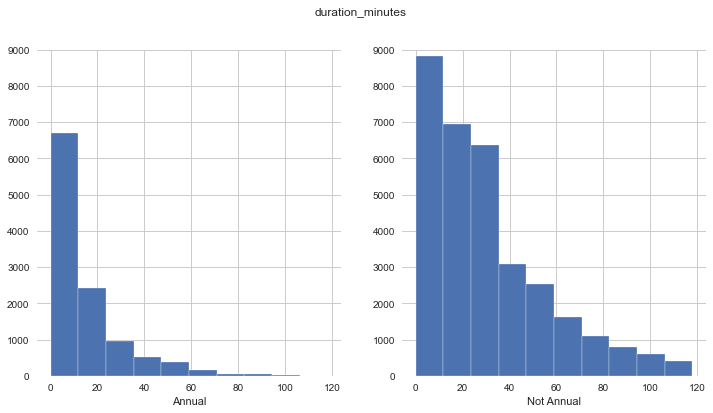

In [220]:
#def histogram_by_subscription(data)
fig, axs = plt.subplots(ncols = 2)
fig.set_size_inches(12, 6)
fig.suptitle('duration_minutes')

axs[0].hist(trips[trips.subscriber_type == 'Annual'].duration_minutes, bins = 10)
axs[0].set_xlabel('Annual')
axs[0].set_ylim(0,9000)
axs[1].hist(trips[trips.subscriber_type != 'Annual'].duration_minutes, bins = 10)
axs[1].set_xlabel('Not Annual')
axs[1].set_ylim(0,9000)

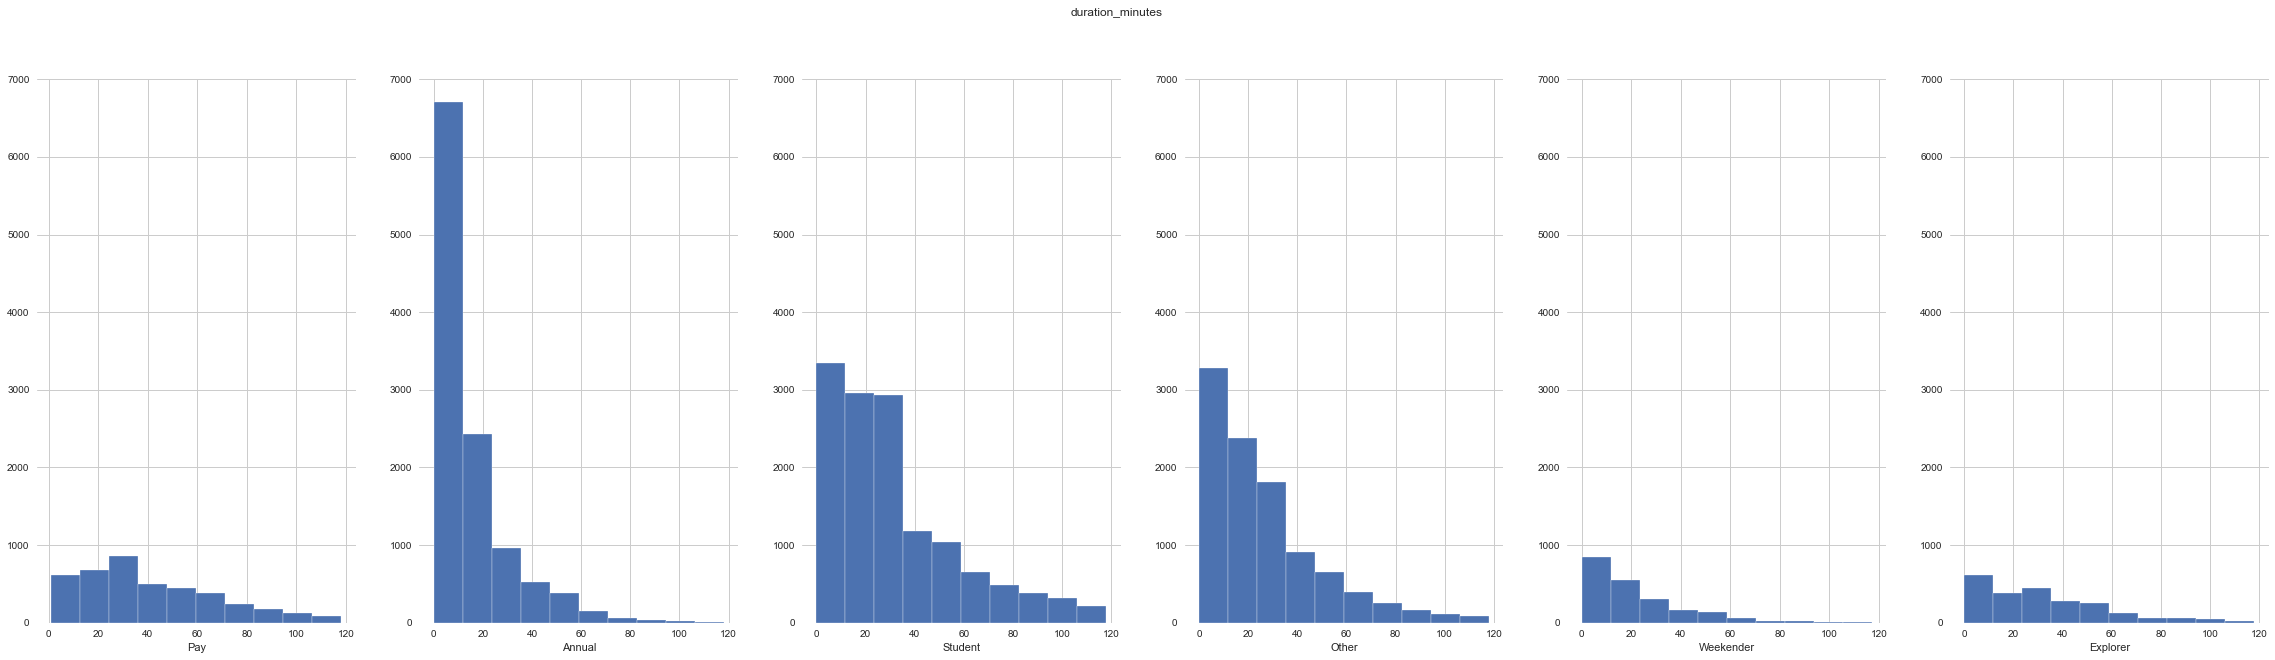

In [219]:
#def histogram_by_subscription(data)
fig, axs = plt.subplots(ncols = 6)
fig.set_size_inches(40, 10)
i = 0
fig.suptitle('duration_minutes')
for _ in set(new_values_dict.values()):
    axs[i].hist(trips[trips.subscriber_type == _].duration_minutes)
    axs[i].set_xlabel(_)
    axs[i].set_ylim(0,7000)
    i+=1

(0.0, 8000.0)

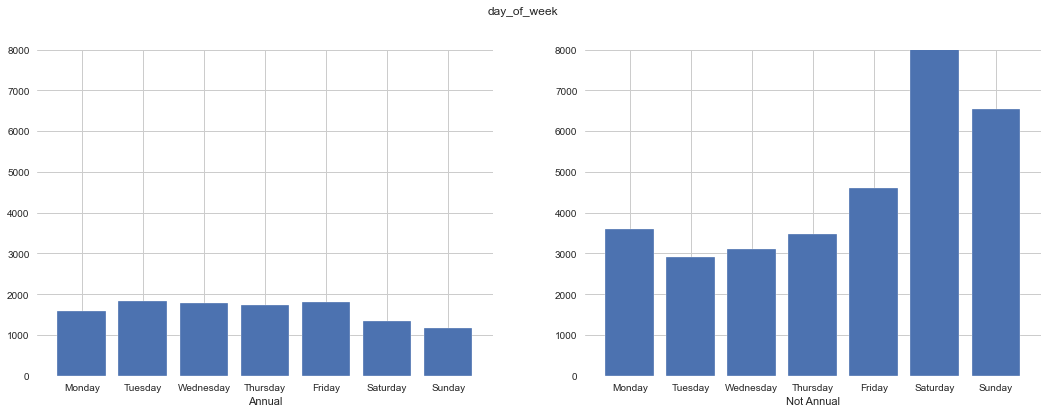

In [218]:
#histogram by day of week
fig, axs = plt.subplots(ncols = 2)
fig.set_size_inches(18, 6)
fig.suptitle('day_of_week')

axs[0].bar(x = trips.day_of_week.value_counts().loc[cats].index, height = trips[trips.subscriber_type == 'Annual'].day_of_week.value_counts().loc[cats])
axs[0].set_xlabel('Annual')
axs[0].set_ylim(0,8000)
axs[1].bar(x = trips.day_of_week.value_counts().loc[cats].index, height = trips[trips.subscriber_type != 'Annual'].day_of_week.value_counts().loc[cats])
axs[1].set_xlabel('Not Annual')
axs[1].set_ylim(0,8000)


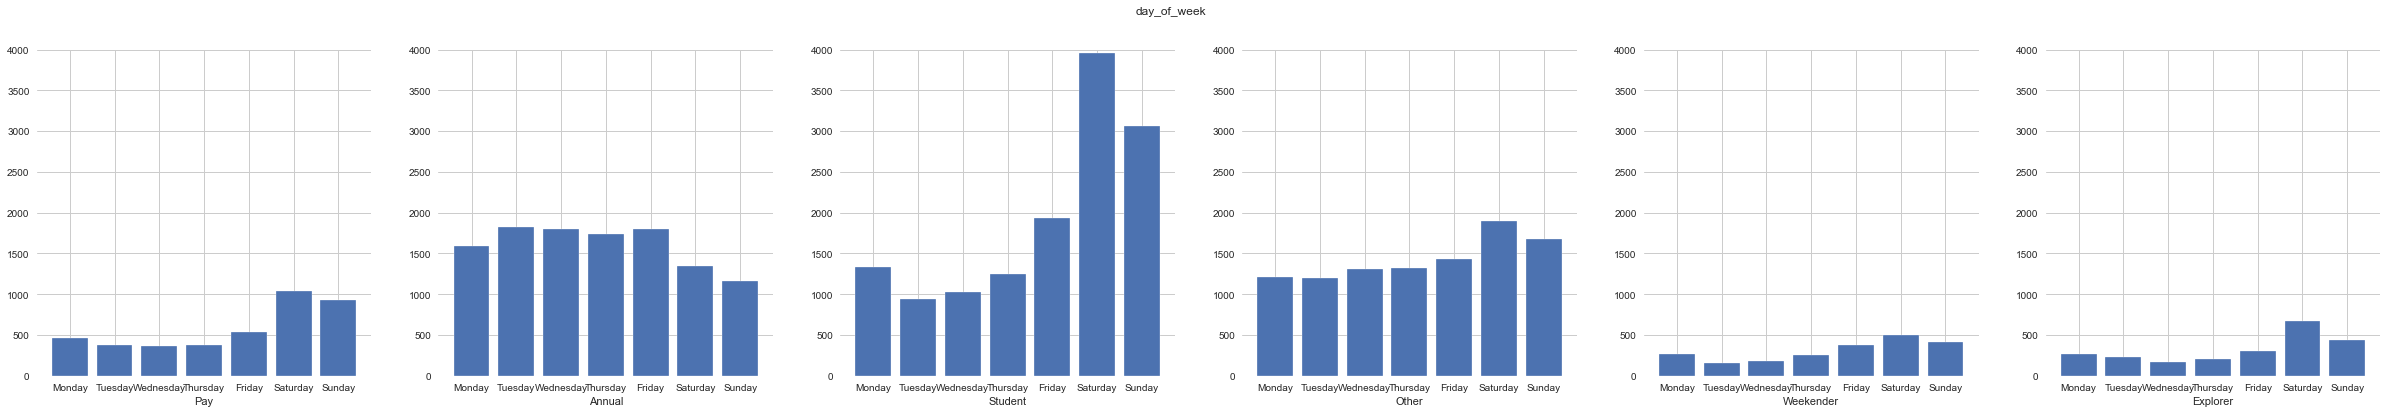

In [217]:

#def histogram by day of week in order
fig, axs = plt.subplots(ncols = 6)
fig.set_size_inches(42, 6)
fig.suptitle('day_of_week')
i = 0
for _ in set(new_values_dict.values()):
    
    axs[i].bar(x = trips.day_of_week.value_counts().loc[cats].index, height = trips[trips.subscriber_type == _].day_of_week.value_counts().loc[cats])
    axs[i].set_xlabel(_)
    axs[i].set_ylim(0,4000)
    i+=1
    

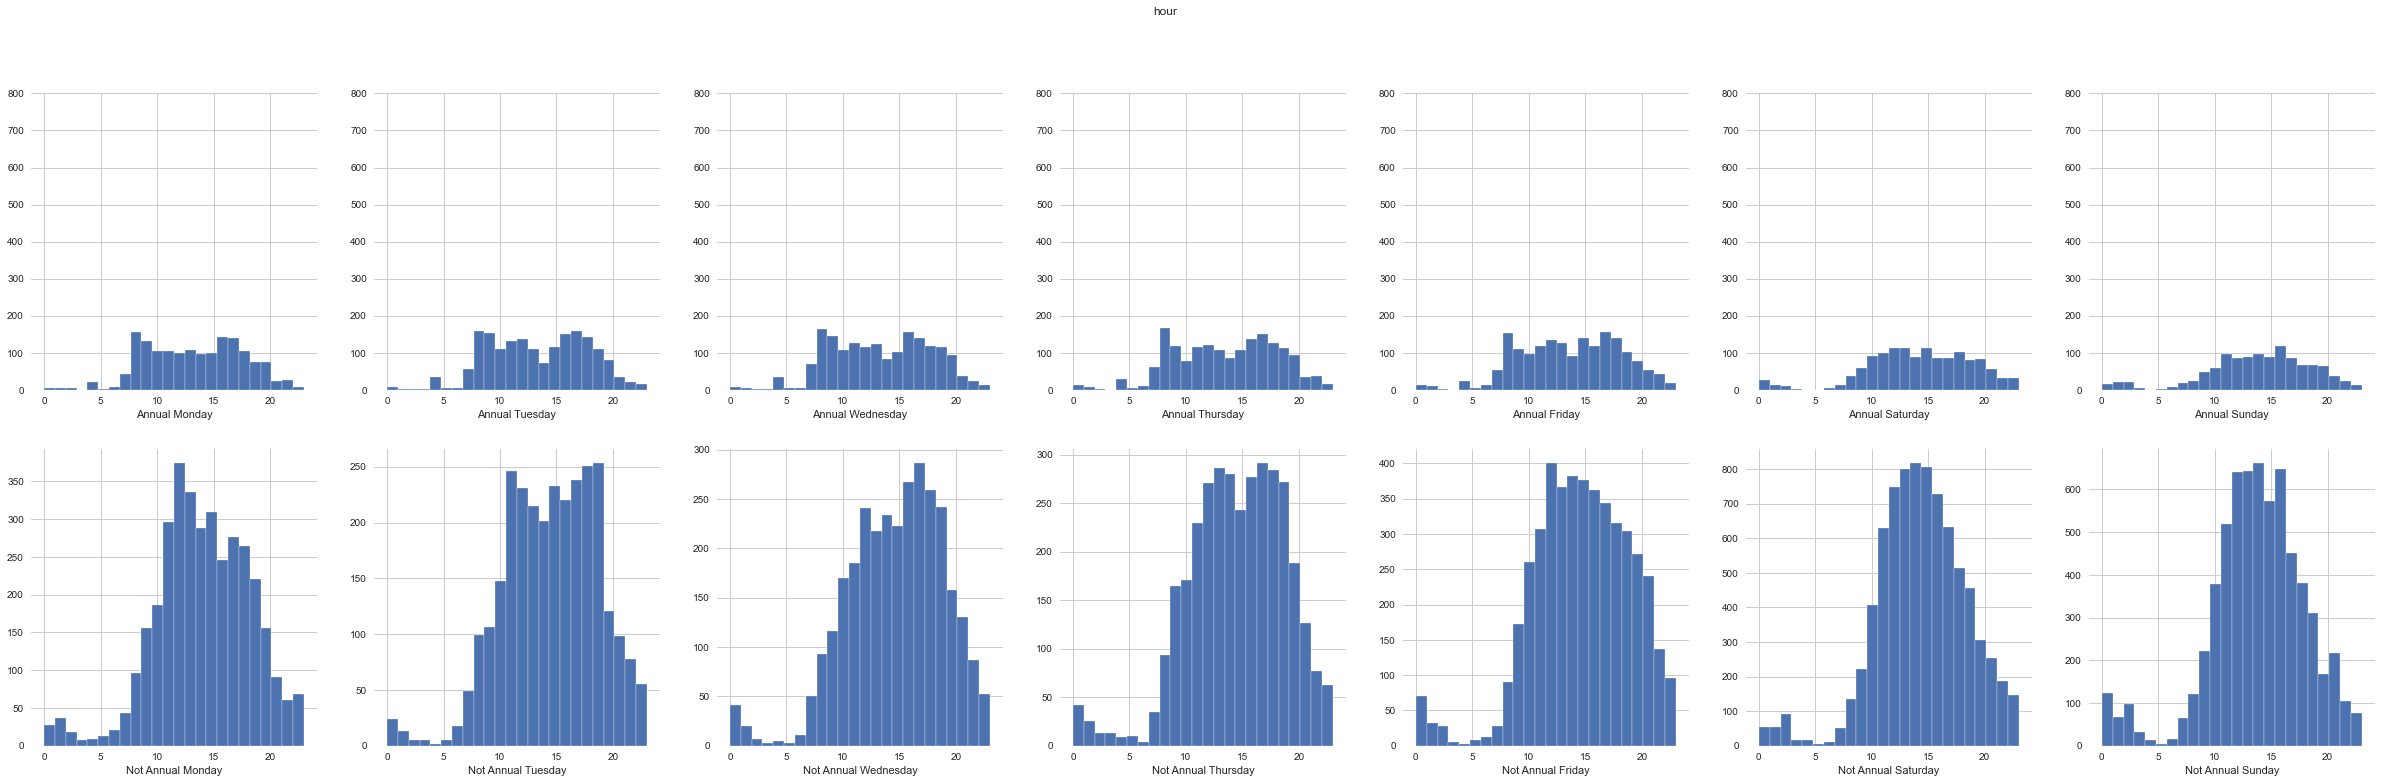

In [214]:
#def histogram_by_subscription(data)
fig, axs = plt.subplots(ncols = 7, nrows = 2 )
fig.set_size_inches(42, 12)
fig.suptitle('hour')
i=0
for day in cats:
    axs[0][i].hist(trips['hour'][(trips['subscriber_type'] == 'Annual')&(trips['day_of_week'] == day)], bins = 24)
    axs[0][i].set_xlabel('Annual '+day)
    axs[0][i].set_ylim(0,800)
    i+=1

i=0
for day in cats:
    axs[1][i].hist(trips['hour'][(trips['subscriber_type'] != 'Annual')&(trips['day_of_week'] == day)], bins = 24)
    axs[1][i].set_xlabel('Not Annual '+day)
    axs[0][i].set_ylim(0,800)
    i+=1

#axs[1].hist(trips[trips.subscriber_type != 'Annual'].hour, bins = 24)
#axs[1].set_xlabel('Not Annual')


# Columns for drawing data on maps
I have decided to add normalized frequency for using in in rgb palette while drawing to map
Grey color is for (almost) unused stations
As the hue of blue color is getting darker, it means the station has more interest

In [169]:
annual_fav_stations = trips['end_station_id'][trips['subscriber_type'] == 'Annual'].value_counts().to_frame()
annual_fav_stations = annual_fav_stations.reset_index().rename(columns = {'index':'station_id','end_station_id':'frequency'})
annual_fav_stations['normalized_freq'] = (annual_fav_stations['frequency']-annual_fav_stations['frequency'].min())/(annual_fav_stations['frequency'].max()-annual_fav_stations['frequency'].min())
annual_fav_stations = pd.merge(annual_fav_stations,stations[['station_id','longitude','latitude']], how = 'left')


In [170]:
not_annual_fav_stations = trips['end_station_id'][trips['subscriber_type'] != 'Annual'].value_counts().to_frame()
not_annual_fav_stations = not_annual_fav_stations.reset_index().rename(columns = {'index':'station_id','end_station_id':'frequency'})
not_annual_fav_stations['normalized_freq'] = (not_annual_fav_stations['frequency']-not_annual_fav_stations['frequency'].min())/(not_annual_fav_stations['frequency'].max()-not_annual_fav_stations['frequency'].min())
not_annual_fav_stations = pd.merge(not_annual_fav_stations,stations[['station_id','longitude','latitude']], how = 'left')


In [171]:
draw_map(annual_fav_stations)

Map(center=[30.2672, -97.7431], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

In [172]:
draw_map(not_annual_fav_stations)

Map(center=[30.2672, -97.7431], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…